## This notebook is for developement and testing for generating topography on cubed-sphere grid based on refined-sampling method

In [1]:
# All imports should be in first cell
import GMesh
import imp  
import inspect
import netCDF4
import numpy as np
from mpl_toolkits.basemap import Basemap
import cartopy
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#utility function to plot grids
PI_180 = np.pi/180.
def plot_mesh_in_latlon(lam, phi, stride=1, phi_color='k', lam_color='r', newfig=True, title=None):
    import matplotlib.pyplot as plt
#    import seaborn as sns; sns.set()
    if (phi.shape != lam.shape): raise Exception('Ooops: lam and phi should have same shape')
    nj,ni = lam.shape
    if(newfig):
        plt.figure(figsize=(10,10))
    for i in range(0,ni,stride):
        plt.plot(lam[:,i],phi[:,i],lam_color)
    for j in range(0,nj,stride):
        plt.plot(lam[j,:],phi[j,:],phi_color)
    if title is not None:
        plt.title(title)
#    plt.show()

def plot_mesh_in_xyz(lam, phi, stride=1, phi_color='k', lam_color='r', lowerlat=None, upperlat=None, newfig=True, title=None):
    if lowerlat is not None:
        lam,phi = cut_below(lam,phi,lowerlat=lowerlat)
    if upperlat is not None:
        lam,phi = cut_above(lam,phi,upperlat=upperlat)
    x = np.cos(phi*PI_180) * np.cos(lam*PI_180)
    y = np.cos(phi*PI_180) * np.sin(lam*PI_180)
    z = np.sin(phi*PI_180)
    plot_mesh_in_latlon(x, y, stride=stride, phi_color=phi_color, lam_color=lam_color, newfig=newfig, title=title)

def cut_below(lam,phi,lowerlat):
    nj,ni = lam.shape
    for j in range(0,nj):
        if(phi[j,0]>lowerlat):
            break
    jmin=j
#    print("jmin",jmin)
    return lam[jmin:,:], phi[jmin:,:]

def cut_above(lam,phi,upperlat):
    nj,ni = lam.shape
    for j in range(0,nj):
        if(phi[j,0]>upperlat):
            break
    jmax=j
#    print("jmax",jmax)
    return lam[0:jmax,:], phi[0:jmax,:]

def mesh_plot(lon,lat, lon0=0.,lat0=90.):
    """Plot a given mesh with a perspective centered at (lon0,lat0)"""
    plt.figure(figsize=(8,8))
    ax = plt.subplot(111, projection=cartopy.crs.NearsidePerspective(central_longitude=lon0, central_latitude=lat0))
    ax.set_global()
    ax.stock_img()
    ax.coastlines()
    ax.gridlines()
    (nj,ni) = lon.shape 
    for i in range(0,ni+1,2):
        ax.plot(lon[:,i], lat[:,i], 'k', transform=cartopy.crs.Geodetic())
    for j in range(0,nj+1,2):
        ax.plot(lon[j,:], lat[j,:], 'k', transform=cartopy.crs.Geodetic())


def write_topo_drag(hmin,hmax,xx,yy,fnam=None,format='NETCDF3_CLASSIC',description=None,history=None,source=None,no_changing_meta=None):
    import netCDF4 as nc

    if fnam is None:
      fnam='topog.nc'
    fout=nc.Dataset(fnam,'w',format=format)

    ny=h.shape[0]; nx=h.shape[1]
    print ('Writing netcdf file ',fnam,' with ny,nx= ',ny,nx)

    ny=fout.createDimension('yaxis_1',ny)
    nx=fout.createDimension('xaxis_1',nx)
    x=fout.createVariable('xaxis_1','f8',('xaxis_1'))
    x.units='meters'
    x[:]=xx
    y=fout.createVariable('yaxis_1','f8',('yaxis_1'))
    y.units='meters'
    y[:]=yy

    h_min=fout.createVariable('hmin','f8',('yaxis_1','xaxis_1'))
    h_min.units='meters'
    h_min[:]=hmin
    h_max=fout.createVariable('hmax','f8',('yaxis_1','xaxis_1'))
    h_max.units='meters'
    h_max[:]=hmax
    
    #global attributes
    if(not no_changing_meta):
        fout.history = history
        fout.description = description
        fout.source =  source

    fout.sync()
    fout.close()

def append_topo_drag(var,var_name,xx,yy,fnam=None,format='NETCDF3_CLASSIC',description=None,history=None,source=None,no_changing_meta=None):
    import netCDF4 as nc

    if fnam is None:
      fnam='topog.nc'
    fout=nc.Dataset(fnam,'a',format=format)

    ny=var.shape[0]; nx=var.shape[1]
    print ('Writing netcdf file ',fnam,' with ny,nx= ',ny,nx)

    t=fout.createVariable(var_name,'f8',('yaxis_1','xaxis_1'))
    t.units='m/s'
    t[:]=var
    
    #global attributes
    if(not no_changing_meta):
        fout.history = history
        fout.description = description
        fout.source =  source

    fout.sync()
    fout.close()

#################
#Helper functions
#################
def mdist(x1,x2):
    """Returns positive distance modulo 360."""
    return np.minimum( np.mod(x1-x2,360.), np.mod(x2-x1,360.) )

def get_indices(lon_grid,lat_grid,x,y):
    """This function returns the j,i indices for the grid point closest to the input lon,lat coordinates."""
    """It returns the j,i indices."""
    lons=np.fabs(lon_grid-x)
    lonm=np.where(lons==lons.min())
    lats=np.fabs(lat_grid-y)
    latm=np.where(lats==lats.min())
    j0=latm[0][0]
    i0=lonm[1][0]
    print("wanted: ",x,y)
    print("got:    ",lon_grid[j0,i0] , lat_grid[j0,i0])
    print(j0,i0)
    return j0,i0

#Gibraltar
#wanted:  32.0 -12.5
#got:     31.9958333333 -12.5041666667
#9299 25439
#Gibraltar
#wanted:  40.7 4.7
#got:     40.6958333333 4.69583333333
#11363 26483
#Black sea
#wanted:  44.0 36
#got:     43.9958333333 36.0041666667
#15120 26879

def get_indices1D(lon_grid,lat_grid,x,y):
    """This function returns the j,i indices for the grid point closest to the input lon,lat coordinates."""
    """It returns the j,i indices."""
#    lons=np.fabs(lon_grid-x)
    lons=np.fabs(mdist(lon_grid,x))
    lonm=np.where(lons==lons.min())
    lats=np.fabs(lat_grid-y)
    latm=np.where(lats==lats.min())
    j0=latm[0][0]
    i0=lonm[0][0]
    print(" wanted: ",x,y)
    print(" got:    ",lon_grid[i0] , lat_grid[j0])
    good=False
    if(abs(x-lon_grid[i0]) < abs(lon_grid[1]-lon_grid[0])):
        good=True
        print("  good")
    else:
        print("  bad")
    print(" j,i=",j0,i0)
    return j0,i0,good

def get_indices1D_m(lon_grid,lat_grid,x,y):
    """This function returns the j,i indices for the grid point closest to the input lon,lat coordinates."""
    """It returns the j,i indices."""
    lons=np.fabs(lon_grid-x)
#    lons=np.fabs(mdist(lon_grid,x))
    lonm=np.where(lons==lons.min())
    lats=np.fabs(lat_grid-y)
    latm=np.where(lats==lats.min())
    j0=latm[0][0]
    i0=lonm[0][0]
    print("wanted: ",x,y)
    print("got:    ",lon_grid[i0] , lat_grid[j0])
    print(j0,i0)
    return j0,i0

In [13]:
import create_topog_refinedSampling as topotool
imp.reload(GMesh) 
imp.reload(topotool)

def zoomzoom_tile(targ_lon,targ_lat,topo_lons,topo_lats,topo_x):    
    jllc,illc,status1=get_indices1D(topo_lons, topo_lats ,targ_lon[0,0] ,targ_lat[0,0])
    jurc,iurc,status2=get_indices1D(topo_lons, topo_lats ,targ_lon[0,-1],targ_lat[-1,0])
    #Translate topo data to start at target_mesh.lon_m[0]
    #Why/When?
    if(not status1 or not status2):
        print(' shifting topo data to start at target lon')
        topo_lons = np.roll(topo_lons,-illc,axis=0) #Roll data longitude to right
        topo_lons = np.where(topo_lons>=topo_lons[0] , topo_lons-360, topo_lons) #Rename (0,60) as (-300,-180) 
        topo_x = np.roll(topo_x,-illc,axis=1) #Roll data depth to the right by the same amount.
    print(' topography grid array shapes: ' , topo_lons.shape,topo_lats.shape,topo_x.shape)
    print(' topography longitude range:',topo_lons.min(),topo_lons.max())
    print(' topography latitude range:',topo_lats.min(),topo_lats.max())
    print(' Is mesh uniform?', GMesh.is_mesh_uniform( topo_lons, topo_lats ) )
    #retest
    jllc,illc,status1=get_indices1D(topo_lons, topo_lats ,targ_lon[0,0] ,targ_lat[0,0])
    jurc,iurc,status2=get_indices1D(topo_lons, topo_lats ,targ_lon[0,-1],targ_lat[-1,0])
    if(not status1 or not status2):
        raise Exception('  **Something went wrong.')
    ## Refine-Sample-Coarsen each block
    #h,hstd,hmin,hmax,hits = topotool.do_block(0,targ_lon,targ_lat,topo_lons,topo_lats,topo_x,max_mb=4000)
    #return h,hstd,hmin,hmax,hits
    return topotool.do_block(0,targ_lon,targ_lat,topo_lons,topo_lats,topo_x,max_mb=4000)

## Read the target grid

In [4]:
#Read in target grid
targ_lon_tile=[]
targ_lat_tile=[]
pathname='/work/Niki.Zadeh/MOM6-examples_myfork/ice_ocean_SIS2/OM4_05/c48/mosaic_c48/'
for tile in range(1,7):
    targ_grid =  netCDF4.Dataset(pathname + 'C48_grid.tile'+str(tile)+'.nc')
    targ_lon=np.array(targ_grid.variables['x'])
    targ_lat=np.array(targ_grid.variables['y'])
    if(tile==4 or tile==5 or tile==6):
        targ_lon=np.transpose(targ_lon)
        targ_lat=np.transpose(targ_lat)
    print("Tile"+str(tile))
    print(" Target mesh shape: ",targ_lon.shape)
    print(" Target mesh corner ll: ",targ_lon[0,0],targ_lat[0,0])
    print(" Target mesh corner ur: ",targ_lon[-1,-1],targ_lat[-1,-1])
    
    if(tile==1 and not np.all(np.diff(targ_lon[0,:])>0)):
        print("   Longitude array is not monotonic. Shifting to make it so...")
        #Niki: come up with a better scheme to remove 60
        targ_lon = np.where(targ_lon>60 , targ_lon-360, targ_lon)
    if(not np.all(np.diff(targ_lon[0,:])>0)):
        print(" Error: Longitude array is still not monotonic!")

    targ_lon_tile.append(targ_lon)
    targ_lat_tile.append(targ_lat)

Tile1
 Target mesh shape:  (97, 97)
 Target mesh corner ll:  305.0 -35.2643896828
 Target mesh corner ur:  35.0 35.2643896828
   Longitude array is not monotonic. Shifting to make it so...
Tile2
 Target mesh shape:  (97, 97)
 Target mesh corner ll:  35.0 -35.2643896828
 Target mesh corner ur:  125.0 35.2643896828
Tile3
 Target mesh shape:  (97, 97)
 Target mesh corner ll:  35.0 35.2643896828
 Target mesh corner ur:  215.0 35.2643896828
Tile4
 Target mesh shape:  (97, 97)
 Target mesh corner ll:  125.0 35.2643896828
 Target mesh corner ur:  215.0 -35.2643896828
Tile5
 Target mesh shape:  (97, 97)
 Target mesh corner ll:  215.0 35.2643896828
 Target mesh corner ur:  305.0 -35.2643896828
Tile6
 Target mesh shape:  (97, 97)
 Target mesh corner ll:  215.0 -35.2643896828
 Target mesh corner ur:  35.0 -35.2643896828


Has North pole, tile  3
Has South pole, tile  6


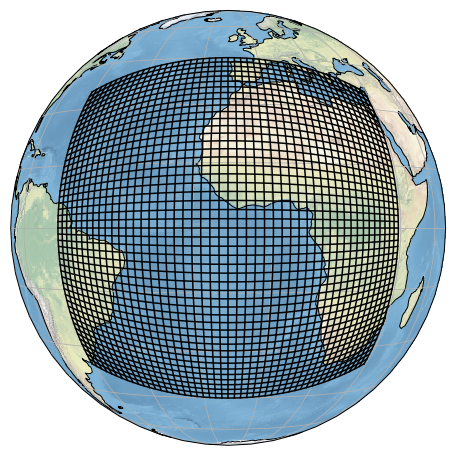

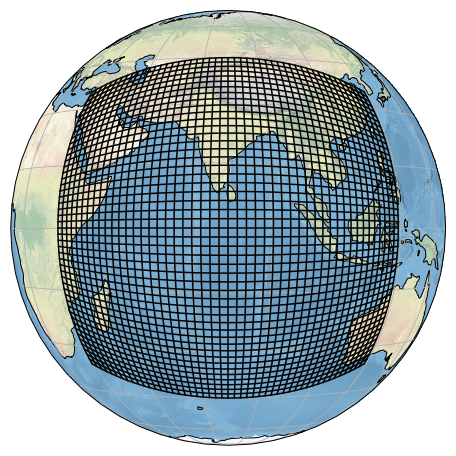

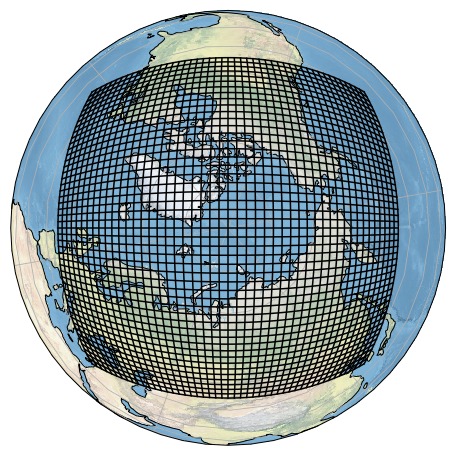

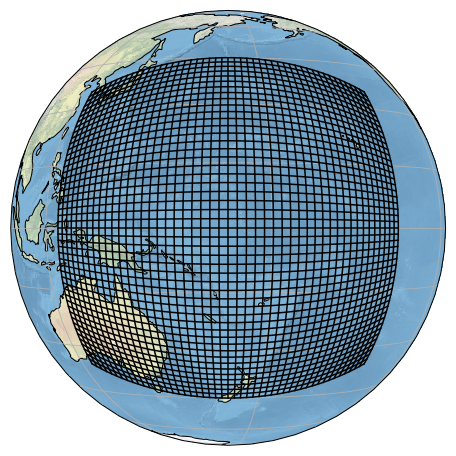

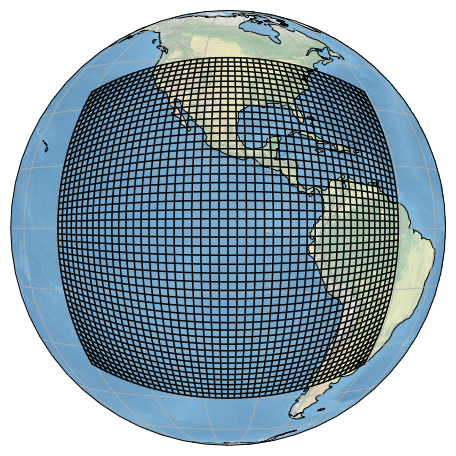

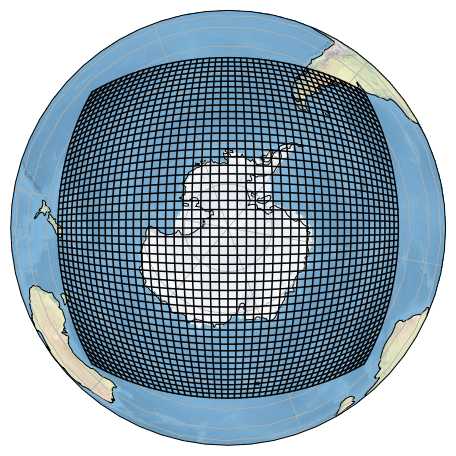

In [5]:
for tile in range(1,7):
    targ_lon=targ_lon_tile[tile-1]
    targ_lat=targ_lat_tile[tile-1]
    lond=targ_lon[0,0]
    latd=targ_lat[0,0]
    lonu=targ_lon[0,-1]
    latu=targ_lat[-1,0]
    lonc=0.5*(lond+lonu)
    latc=0.5*(latd+latu)
    if((targ_lat[1,1]-targ_lat[0,0])*(targ_lat[-1,-1]-targ_lat[-2,-2]) < 0):
        if((targ_lat[1,1]-targ_lat[0,0]) < 0):
            print("Has South pole, tile ",tile)
            latc=-90.
        else:
            print("Has North pole, tile ",tile)
            latc=90.    

    mesh_plot(targ_lon,targ_lat,lon0=lonc,lat0=latc)

## Read dataset for topography

In [6]:
# # Open and read the topographic dataset
#url,vx,vy,ve = '/archive/William.Cooke/DATA/topo_drag/poztopog.nc','lon','lat','hpos'
url,vx,vy,ve = '/work/Niki.Zadeh/MOM6-examples_myfork/ice_ocean_SIS2/OM4_05/c48/poztopog.nc','lon','lat','hpoz'
src_data = netCDF4.Dataset(url)
# Read coordinates of topography
src_lons = np.array( src_data.variables[vx][:] )
src_lats = np.array( src_data.variables[vy][:] )
src_elvs = np.array( src_data.variables[ve][:,:] )
print(' source grid array shapes: ' , src_lons.shape,src_lats.shape,src_elvs.shape)
print(' source longitude range:',src_lons.min(),src_lons.max())
print(' source latitude range:',src_lats.min(),src_lats.max())
print(' Is source mesh uniform?', GMesh.is_mesh_uniform( src_lons, src_lats ) )

 source grid array shapes:  (21600,) (10800,) (10800, 21600)
 source longitude range: 0.00833333 359.992
 source latitude range: -89.9917 89.9917
 Is source mesh uniform? True


## zoomzoom algorithm to interpolate source data to target grid

In [7]:
#Values used by Steve Garner
tiny=1.0e-14
epsi=0.0
beta=0.5
gamma=0.4
if (gamma == beta + epsi):
    gamma = gamma + tiny
exponent = 2. - gamma
h_frac=0.1
stg_coeff=((gamma + 2.)/(2.*gamma)*(1. - h_frac**(2.*gamma))/(1. - h_frac**(gamma + 2.)))**(1.0/exponent) 

src_x=src_elvs
var_name='hmin'
src_var=src_elvs
for tile in range(1,7):
    print('==========\nTile %1d \n=========\n' % tile)
    h,hstd,hmin,hmax,hits = zoomzoom_tile(targ_lon_tile[tile-1],targ_lat_tile[tile-1],src_lons,src_lats,src_var)
    #Steve Garner's formulation for hmin,hmax
    stg_hmax = stg_coeff*h
    stg_hmin = stg_hmax*h_frac
    write_topo_drag(stg_hmin,stg_hmax,targ_lon[0,:],targ_lat[:,0],fnam='topo_drag.res.tile'+str(tile)+'.nc',no_changing_meta=True)

Tile 1 

 wanted:  -55.0 -35.2643896828
 got:     304.992 -35.2583
  bad
 j,i= 3284 18299
 wanted:  35.0 35.2643896828
 got:     34.9917 35.2583
  good
 j,i= 7515 2099
 shifting topo data to start at target lon
 topography grid array shapes:  (21600,) (10800,) (10800, 21600)
 topography longitude range: -55.0083 304.975
 topography latitude range: -89.9917 89.9917
 Is mesh uniform? True
 wanted:  -55.0 -35.2643896828
 got:     -55.0083 -35.2583
  good
 j,i= 3284 0
 wanted:  35.0 35.2643896828
 got:     34.9917 35.2583
  good
 j,i= 7515 5400
  Doing block number  0
  Target sub mesh shape:  (97, 97)
  Slices j,i: slice(2700, 8100, 2) slice(0, 5401, 2)
  Topo shape: (2700, 2701)
  topography longitude range: -55.0083 34.9917
  topography latitude  range: -44.9917 44.975
  Target     longitude range: -55.0 35.0
  Target     latitude  range: -45.0 45.0
  Refining the target to hit all source points ...
<GMesh nj:96 ni:96 shape:(96,96)> Hit 9409 out of 7292700 cells (0.1406 Mb)
<GMesh nj:19

<GMesh nj:768 ni:768 shape:(768,768)> Hit 591361 out of 7292700 cells (9.0000 Mb)
<GMesh nj:1536 ni:1536 shape:(1536,1536)> Hit 2362369 out of 7292700 cells (36.0000 Mb)
<GMesh nj:3072 ni:3072 shape:(3072,3072)> Hit 6788349 out of 7292700 cells (144.0000 Mb)
<GMesh nj:6144 ni:6144 shape:(6144,6144)> Hit 6788612 out of 7292700 cells (576.0000 Mb)
<GMesh nj:12288 ni:12288 shape:(12288,12288)> Hit 6788738 out of 7292700 cells (2304.0000 Mb)
  non-hit ratio:  503962  /  7292700
  Sampling the source points on target mesh ...
  Sampling finished...
  Coarsening back to the original taget grid ...

Writing netcdf file  topo_drag.res.tile5.nc  with ny,nx=  97 97
Tile 6 

 wanted:  215.0 -35.2643896828
 got:     214.992 -35.2583
  good
 j,i= 3284 12899
 wanted:  305.0 -35.2643896828
 got:     304.992 -35.2583
  good
 j,i= 3284 18299
 topography grid array shapes:  (21600,) (10800,) (10800, 21600)
 topography longitude range: 0.00833333 359.992
 topography latitude range: -89.9917 89.9917
 Is m

In [8]:
# # Open and read the topographic dataset
#url,vx,vy,ve = '/archive/William.Cooke/DATA/src_drag/poztopog.nc','lon','lat','hpos'
url,vx,vy,t11,t21,t22 = '/work/Niki.Zadeh/MOM6-examples_myfork/ice_ocean_SIS2/OM4_05/c48/dragelements.nc','lon','lat','t11','t21','t22'
src_data = netCDF4.Dataset(url)
# Read coordinates of topography
src_lons = np.array( src_data.variables[vx][:] )
src_lats = np.array( src_data.variables[vy][:] )
print(' topography grid array shapes: ' , src_lons.shape,src_lats.shape,src_t11.shape)
print(' topography longitude range:',src_lons.min(),src_lons.max())
print(' topography latitude range:',src_lats.min(),src_lats.max())
print(' Is source mesh uniform?', GMesh.is_mesh_uniform( src_lons, src_lats ) )

 topography grid array shapes:  (21600,) (10800,) (10800, 21600)
 topography longitude range: 0.00833333 359.992
 topography latitude range: -89.9917 89.9917
 Is source mesh uniform? True


In [16]:
#Values used by Steve Garner
bfscale=1.0e-2 # buoyancy frequency scale [1/s]

for var_name in ('t11','t22','t21'):
    src_var=np.array( src_data.variables[var_name][:,:] )
    for tile in range(1,7):
        print('==========\nTile %1d \n=========\n' % tile)
        h,hstd,hmin,hmax,hits = zoomzoom_tile(targ_lon_tile[tile-1],targ_lat_tile[tile-1],src_lons,src_lats,src_var)
        #Steve Garner's formulation for tij
        t = h/bfscale
        append_topo_drag(t,var_name,targ_lon[0,:],targ_lat[:,0],fnam='topo_drag.res.tile'+str(tile)+'.nc',no_changing_meta=True)   
        if(var_name == 't21'):
            append_topo_drag(t,'t12',targ_lon[0,:],targ_lat[:,0],fnam='topo_drag.res.tile'+str(tile)+'.nc',no_changing_meta=True)   

Tile 1 

 wanted:  -55.0 -35.2643896828
 got:     304.992 -35.2583
  bad
 j,i= 3284 18299
 wanted:  35.0 35.2643896828
 got:     34.9917 35.2583
  good
 j,i= 7515 2099
 shifting topo data to start at target lon
 topography grid array shapes:  (21600,) (10800,) (10800, 21600)
 topography longitude range: -55.0083 304.975
 topography latitude range: -89.9917 89.9917
 Is mesh uniform? True
 wanted:  -55.0 -35.2643896828
 got:     -55.0083 -35.2583
  good
 j,i= 3284 0
 wanted:  35.0 35.2643896828
 got:     34.9917 35.2583
  good
 j,i= 7515 5400
  Doing block number  0
  Target sub mesh shape:  (97, 97)
  Slices j,i: slice(2700, 8100, 2) slice(0, 5401, 2)
  Topo shape: (2700, 2701)
  topography longitude range: -55.0083 34.9917
  topography latitude  range: -44.9917 44.975
  Target     longitude range: -55.0 35.0
  Target     latitude  range: -45.0 45.0
  Refining the target to hit all source points ...
<GMesh nj:96 ni:96 shape:(96,96)> Hit 9409 out of 7292700 cells (0.1406 Mb)
<GMesh nj:19

<GMesh nj:768 ni:768 shape:(768,768)> Hit 591361 out of 7292700 cells (9.0000 Mb)
<GMesh nj:1536 ni:1536 shape:(1536,1536)> Hit 2362369 out of 7292700 cells (36.0000 Mb)
<GMesh nj:3072 ni:3072 shape:(3072,3072)> Hit 6788349 out of 7292700 cells (144.0000 Mb)
<GMesh nj:6144 ni:6144 shape:(6144,6144)> Hit 6788612 out of 7292700 cells (576.0000 Mb)
<GMesh nj:12288 ni:12288 shape:(12288,12288)> Hit 6788738 out of 7292700 cells (2304.0000 Mb)
  non-hit ratio:  503962  /  7292700
  Sampling the source points on target mesh ...
  Sampling finished...
  Coarsening back to the original taget grid ...

Writing netcdf file  topo_drag.res.tile5.nc  with ny,nx=  97 97
Tile 6 

 wanted:  215.0 -35.2643896828
 got:     214.992 -35.2583
  good
 j,i= 3284 12899
 wanted:  305.0 -35.2643896828
 got:     304.992 -35.2583
  good
 j,i= 3284 18299
 topography grid array shapes:  (21600,) (10800,) (10800, 21600)
 topography longitude range: 0.00833333 359.992
 topography latitude range: -89.9917 89.9917
 Is m

  non-hit ratio:  2926259  /  17741114
  Sampling the source points on target mesh ...
  Sampling finished...
  Coarsening back to the original taget grid ...

Writing netcdf file  topo_drag.res.tile3.nc  with ny,nx=  97 97
Writing netcdf file  topo_drag.res.tile3.nc  with ny,nx=  97 97
Tile 4 

 wanted:  125.0 35.2643896828
 got:     124.992 35.2583
  good
 j,i= 7515 7499
 wanted:  215.0 -35.2643896828
 got:     214.992 -35.2583
  good
 j,i= 3284 12899
 topography grid array shapes:  (21600,) (10800,) (10800, 21600)
 topography longitude range: 0.00833333 359.992
 topography latitude range: -89.9917 89.9917
 Is mesh uniform? True
 wanted:  125.0 35.2643896828
 got:     124.992 35.2583
  good
 j,i= 7515 7499
 wanted:  215.0 -35.2643896828
 got:     214.992 -35.2583
  good
 j,i= 3284 12899
  Doing block number  0
  Target sub mesh shape:  (97, 97)
  Slices j,i: slice(2700, 8100, 2) slice(7499, 12900, 2)
  Topo shape: (2700, 2701)
  topography longitude range: 124.992 214.992
  topograph

In [17]:
url,vx,vy,hmin,t11,t21,t22 = 'topo_drag.res.tile2.nc','xaxis_1','yaxis_1','hmin','t11','t21','t22'
topo_data = netCDF4.Dataset(url)
# Read coordinates of topography
topo_lons = np.array( topo_data.variables[vx][:] )
topo_lats = np.array( topo_data.variables[vy][:] )
topo_hmin = np.array( topo_data.variables[hmin][:,:] )
topo_t11 = np.array( topo_data.variables[t11][:,:] )
#topo_t21 = np.array( topo_data.variables[t21][:,:] )
topo_t22 = np.array( topo_data.variables[t22][:,:] )
print(' topography grid array shapes: ' , topo_lons.shape,topo_lats.shape,topo_t11.shape)
print(' topography longitude range:',topo_lons.min(),topo_lons.max())
print(' topography latitude range:',topo_lats.min(),topo_lats.max())

 topography grid array shapes:  (97,) (97,) (97, 97)
 topography longitude range: 215.0 305.0
 topography latitude range: -45.0 -35.2643896828


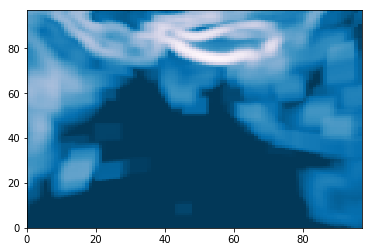

In [18]:
import matplotlib.colors as colors
cmap = plt.get_cmap('magma')
plt.pcolormesh(topo_hmin, norm=colors.PowerNorm(gamma=0.5),
                       cmap='PuBu_r')